# Neural Network from Scratch
Code modified from http://adventuresinmachinelearning.com/neural-networks-tutorial/ 

The notation in this website is almost the same as the notation we are using in class.  Instead of using $a$ for activations the author uses $h$, and instead of $N$ for the number of training examples, the author uses $m$. (I have modified the code below to use $a$ and $N$.)

Please read about this implementation starting at page 27 from the website listed above.

## The first thing we will do is import all the libraries

We will be using the lower resolution MINST data set

In [1]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
from math import exp

# Part I: Homework Reuse:

## Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

The shape of the digits dataset:
(1797, 64)


<Figure size 432x288 with 0 Axes>

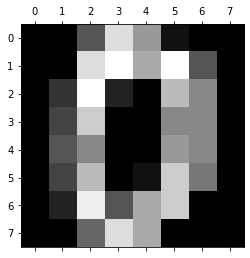

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [2]:
digits=load_digits()
X = digits.data
print("The shape of the digits dataset:") 
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()
y = digits.target
print(y[0:1])
print(X[0,:])

## 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [3]:
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

X[0,:] # Looking the new features after scaling

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

## 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [4]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

## 3) Setting up the output layer

### One-vs-all encoding
Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.  

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

Thus we need to change our target so it is the same as our hoped for output of the neural network.  
-  If $y=0$ we change it into the vector $(1,0,0,0,0,0,0,0,0,0)$. 
-  If $y=1$ we change it into the vector $(0,1,0,0,0,0,0,0,0,0)$
-  etc

See page 29 from the website listed above

The code to covert the target vector.

In [5]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

Converting the training and test targets to vectors 

In [6]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

A quick check to see that our code performs as we expect 

In [7]:
print(y_train[0:4])
print(y_v_train[0:4])

[1 6 8 3]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## 4) Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [8]:
def d_relu_helper(x):
    if x<0:
        return 0
    else:
        return 1

def f(z, function = 0):
    # default, 0 for sigmoid
    # 1 for relu
    # 2 for tanh
        
    if function == 1:
        return np.maximum(0,z)
    elif function == 2:
        return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    #default case
    return 1 / (1 + np.exp(-z))


def f_deriv(z, function = 0):
    # 0 for sigmoid
    # 1 for relu
    # 2 for tanh
    if function == 1:
        temp = np.array(z)
        temp[temp <0] = 0
        temp[temp >=0] = 1
        return temp
    elif function == 2:
        f_value = f(z, function=2)
        return 1 - f_value*f_value
    #default case
    return f(z) * (1 - f(z))
    

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [9]:
def setup_and_init_weights(nn_structure, mode = False):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    if mode:
        print("He normal innitialization")
        for l in range(1, len(nn_structure)):
            W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))*np.sqrt(2/nn_structure[l-1]) #He normal innitialization
            b[l] = r.random_sample((nn_structure[l],))
    else:  
        print("Uniform innitialization")
        for l in range(1, len(nn_structure)):
            W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
            b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [10]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [11]:
def feed_forward(x, W, b, function = 0):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1], function) # a^(l+1) = f(z^(l+1))
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [12]:
def calculate_out_layer_delta(y, a_out, z_out, function = 0):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out, function) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l, function=0):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l, function)

## The Back Propagation Algorithm


In [13]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, lamb = 0.001, function = 0, innit_mode = False):
    if function == 1:
        print("Use ReLU activation")
    elif function == 2:
        print("Use tanh activation")
    else:
        print("Use sigmoid activation")
    W, b = setup_and_init_weights(nn_structure, mode=innit_mode)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b, function)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l], function)
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l], function)
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l] + lamb * W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers, function = 0):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b, function= function)
        y[i] = np.argmax(a[n_layers])
    return y

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [14]:
nn_structure = [64, 30, 10]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, lamb = 0)

Use sigmoid activation
Uniform innitialization
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


### Plotting the learning curve


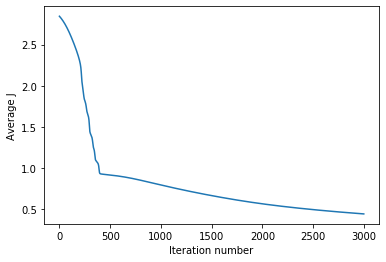

In [15]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

## 5) Assessing accuracy
Next we determine what percentage the neural network correctly predicted the handwritten digit correctly on the test set

In [16]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 86.92628650904032%


Use sigmoid activation
Uniform innitialization
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


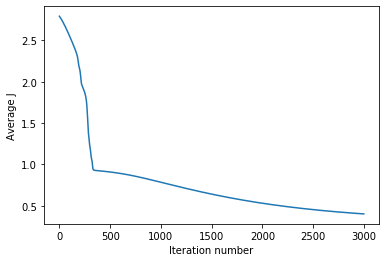

Prediction accuracy is 93.46314325452016%


In [17]:
# ReLU function
nn_structure = [64, 30, 10]
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, function=0)
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, 0)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Use ReLU activation
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


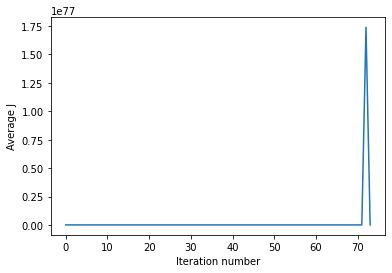

Prediction accuracy is 10.570236439499304%


In [15]:
# ReLU function
nn_structure = [64, 30, 10]
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, function=1)
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, 1)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Use tanh activation
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


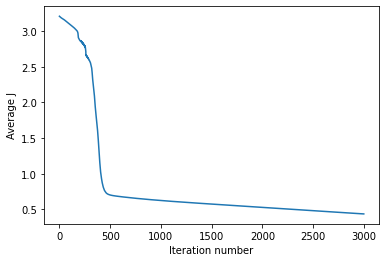

Prediction accuracy is 92.76773296244785%


In [68]:
# tanh function
nn_structure = [64, 30, 10]
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, function = 2)
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, 2)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Use sigmoid activation
He normal innitialization
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


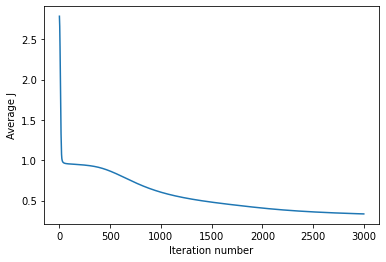

Prediction accuracy is 94.99304589707927%


In [24]:
# Sigmoid function He innitialization
nn_structure = [64, 30, 10]
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, function=0, innit_mode=True)
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, 0)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Use sigmoid activation
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


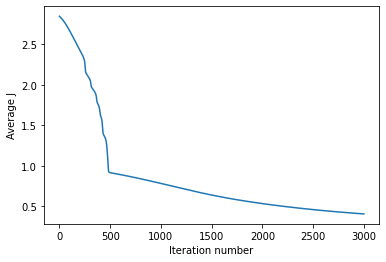

Prediction accuracy is 91.3769123783032%


In [16]:
# Sigmoid function with different hiden node number
nn_structure = [64, 40, 10]
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, function=0)
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, 0)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Use sigmoid activation
He normal innitialization
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


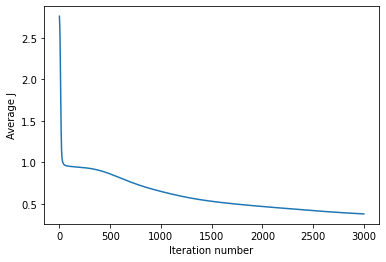

Prediction accuracy is 94.57579972183588%


In [26]:
# Sigmoid function with different hiden node number
nn_structure = [64, 20, 10]
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, function=0, innit_mode=True)
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3, 0)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

# Part II: Extension: Adding Pooling and convolution layers
## 1. Train homework data with CNN

In [42]:
### reference: https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1
def convolution(image, filt, bias, s=1):
    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    n_c, in_dim, _ = image.shape # image dimensions
    
    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
    
    
    out = np.zeros((n_f,out_dim,out_dim))
    
    # convolve the filter over every part of the image, adding the bias at each step. 
    for curr_f in range(n_f):
        curr_y = out_y = 0
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            while curr_x + f <= in_dim:
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return out

In [44]:
def maxpool(image, f=2, s=2):
    '''
    Downsample `image` using kernel size `f` and stride `s`
    '''
    n_c, h_prev, w_prev = image.shape
    
    h = int((h_prev - f)/s)+1
    w = int((w_prev - f)/s)+1
    
    downsampled = np.zeros((n_c, h, w))
    for i in range(n_c):
        # slide maxpool window over each part of the image and assign the max value at each step to the output
        curr_y = out_y = 0
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled

In [43]:
def train(X,y,num_classes = 10, alpha = 0.01, beta1 = 0.95, beta2 = 0.99, img_dim = 8, img_depth = 1, f = 5, num_filt1 = 32, num_filt2 = 32, batch_size = 32, num_epochs = 2):
    train_data = np.hstack((X,y))
    
    np.random.shuffle(train_data)

    ## Initializing all the parameters
    if img_dim ==28:
        f = 5
        num_filt1 = 8
        num_filt2 = 8
        f1, f2, w1, w2 = (num_filt1 ,img_depth,f,f), (num_filt2 ,num_filt1,f,f), (128,800), (10, 128)

    elif img_dim == 8:
        f = 2
        f1, f2, w1, w2 = (num_filt1 ,img_depth,f,f), (num_filt2 ,num_filt1,f,f), (128,288), (10, 128)
    else:
        print("Thia img_dim has not been implemented")
    f1 = initializeFilter(f1)
    f2 = initializeFilter(f2)
    w1,b3 = setup_and_init_weights_cnn(w1)
    w2,b4 = setup_and_init_weights_cnn(w2)
    b1 = np.zeros((f1.shape[0],1))
    b2 = np.zeros((f2.shape[0],1))

    params = [f1, f2, w1, w2, b1, b2, b3, b4]

    cost = []

    print("LR:"+str(alpha)+", Batch Size:"+str(batch_size))

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]
        for batch in batches:
            params, cost = graduate_descent(batch, num_classes, alpha, img_dim, img_depth, beta1, beta2, params, cost)
    
    return (params, cost)

In [26]:
def nanargmax(arr):
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs

In [27]:
digits = load_digits()
X = digits.data
y = np.array([[yy] for yy in digits.target])
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, test_size=0.4)
img_dim = 8
(params, cost) = train(X = X_train, y = y_train,alpha = 0.02, img_dim = img_dim)

LR:0.02, Batch Size:32


In [28]:
[f1, f2, w1, w2, b1, b2, b3, b4] = params

In [29]:
def predict(image, f1, f2, w1, w2, b1, b2, b3, b4, conv_s = 1, pool_f = 2, pool_s = 2):
    '''
    Make predictions with trained filters/weights. 
    '''
    conv1 = convolution(image, f1, b1, conv_s) # convolution operation
    conv1[conv1<=0] = 0 #relu activation
    
    conv2 = convolution(conv1, f2, b2, conv_s) # second convolution operation
    conv2[conv2<=0] = 0 # pass through ReLU non-linearity
    
    pooled = maxpool(conv2, pool_f, pool_s) # maxpooling operation
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer
    
    z = w1.dot(fc) + b3 # first dense layer
    z[z<=0] = 0 # pass through ReLU non-linearity
    
    out = w2.dot(z) + b4 # second dense layer
    probs = softmax(out) # predict class probabilities with the softmax activation function
    
    return np.argmax(probs), np.max(probs)

In [34]:
X = X_test
y_dash = y_test
X-= int(np.mean(X)) # subtract mean
X/= int(np.std(X)) # divide by standard deviation
test_data = np.hstack((X,y_dash))
    
X = test_data[:,0:-1]
X = X.reshape(len(test_data), 1,img_dim, img_dim)
y = test_data[:,-1]

corr = 0
digit_count = [0 for i in range(10)]
digit_correct = [0 for i in range(10)]
   
#t = tqdm(range(len(X)), leave=True)

for i in range(len(X)):
    x = X[i]
    pred, prob = predict(x, f1, f2, w1, w2, b1, b2, b3, b4)
    digit_count[int(y[i])]+=1
    if pred==y[i]:
        corr+=1
        digit_correct[pred]+=1

   # t.set_description("Acc:%0.2f%%" % (float(corr/(i+1))*100))
        
print("Prediction Accuracy is: "+ str(float(corr/len(test_data)*100)))

Prediction Accuracy is: 90.513512345635678%


## 2. Train MNIST data with CNN:

In [37]:
def extract_data(filename, num_images, IMAGE_WIDTH):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_WIDTH * IMAGE_WIDTH * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH*IMAGE_WIDTH)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

def initializeFilter(size, scale = 1.0):
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

def initializeWeight(size):
    return np.random.standard_normal(size=size) * 0.005

In [45]:
def maxpoolBackward(dpool, orig, f, s):
    (n_c, orig_dim, _) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window
                (a, b) = nanargmax(orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f])
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]
                
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return dout

def convolutionBackward(dconv_prev, conv_in, filt, s):
    '''
    Backpropagation through a convolutional layer. 
    '''
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias

In [39]:
def conv(image, label, params, conv_s, pool_f, pool_s):
    
    [f1, f2, w1, w2, b1, b2, b3, b4] = params 
    #w1 &b3 are layer1, w2 &b4 are layer 2, f1&b1 are convolution of layer1, f2&b2 are  convolution of layer2
    
    #feedforward
    conv1 = convolution(image, f1, b1, conv_s)
    conv1[conv1<=0] = 0 #use Relu instead of f(z)
    #conv1 = f(conv1)
       
    conv2 = convolution(conv1, f2, b2, conv_s)
    conv2[conv2<=0] = 0
    #conv2 = f(conv2)
    
    pooled = maxpool(conv2, pool_f, pool_s) # find the max in neighbours
    
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1))
    z = w1.dot(fc) + b3
    #z = f(z)
    z[z<=0] = 0 
    
    out = w2.dot(z) + b4
     
    probs = softmax(out) 
    loss = categoricalCrossEntropy(probs, label)
    
    #backpropagation

    dout = probs - label 
    dw2 = dout.dot(z.T) 
    db4 = np.sum(dout, axis = 1).reshape(b4.shape)
    
    dz = w2.T.dot(dout) 
    #dz = f_deriv(dz)
    dz[z<=0] = 0 # backpropagate through ReLU 
    dw1 = dz.dot(fc.T)
    db3 = np.sum(dz, axis = 1).reshape(b3.shape)
    
    dfc = w1.T.dot(dz) 
    dpool = dfc.reshape(pooled.shape) # reshape fully connected into dimensions of pooling layer
    
    dconv2 = maxpoolBackward(dpool, conv2, pool_f, pool_s) 
    dconv2[conv2<=0] = 0 # backpropagate through ReLU
    #dconv2 = f_deriv(dconv2)
    
    dconv1, df2, db2 = convolutionBackward(dconv2, conv1, f2, conv_s) 
    dconv1[conv1<=0] = 0 # backpropagate through ReLU
    #dconv1 = f_deriv(dconv1)
    
    dimage, df1, db1 = convolutionBackward(dconv1, image, f1, conv_s)
    
    grads = [df1, df2, dw1, dw2, db1, db2, db3, db4] 
    
    return grads, loss

In [40]:
def setup_and_init_weights_cnn(nn_structure):

    W = np.random.standard_normal(size=nn_structure)*0.01
    b = np.zeros((W.shape[0],1))
    return W, b

In [41]:
def graduate_descent(batch, num_classes, alpha, dim, n_c, beta1, beta2, params, cost):
    [f1, f2, w1, w2, b1, b2, b3, b4] = params
    
    X = batch[:,0:-1] # get batch inputs
    X = X.reshape(len(batch), n_c, dim, dim)
    Y = batch[:,-1] # get batch labels
    
    cost_ = 0
    batch_size = len(batch)
    
    # initialize gradients and momentum,RMS params
    df1 = np.zeros(f1.shape)
    df2 = np.zeros(f2.shape)
    dw1 = np.zeros(w1.shape)
    dw2 = np.zeros(w2.shape)
    db1 = np.zeros(b1.shape)
    db2 = np.zeros(b2.shape)
    db3 = np.zeros(b3.shape)
    db4 = np.zeros(b4.shape)
    
    v1 = np.zeros(f1.shape)
    v2 = np.zeros(f2.shape)
    v3 = np.zeros(w1.shape)
    v4 = np.zeros(w2.shape)
    bv1 = np.zeros(b1.shape)
    bv2 = np.zeros(b2.shape)
    bv3 = np.zeros(b3.shape)
    bv4 = np.zeros(b4.shape)
    
    s1 = np.zeros(f1.shape)
    s2 = np.zeros(f2.shape)
    s3 = np.zeros(w1.shape)
    s4 = np.zeros(w2.shape)
    bs1 = np.zeros(b1.shape)
    bs2 = np.zeros(b2.shape)
    bs3 = np.zeros(b3.shape)
    bs4 = np.zeros(b4.shape)
    
    for i in range(batch_size):
        
        x = X[i]
        y = np.eye(num_classes)[int(Y[i])].reshape(num_classes, 1) # convert label to one-hot
        
        # Collect Gradients for training example
        grads, loss = conv(x, y, params, 1, 2, 2)
        [df1_, df2_, dw1_, dw2_, db1_, db2_, db3_, db4_] = grads
        
        df1+=df1_
        db1+=db1_
        df2+=df2_
        db2+=db2_
        dw1+=dw1_
        db3+=db3_
        dw2+=dw2_
        db4+=db4_

        cost_+= loss

    # Parameter Update  
        
    v1 = beta1*v1 + (1-beta1)*df1/batch_size # momentum update
    s1 = beta2*s1 + (1-beta2)*(df1/batch_size)**2 # RMSProp update
    f1 -= alpha * v1/np.sqrt(s1+1e-7) # combine momentum and RMSProp to perform update with Adam
    
    bv1 = beta1*bv1 + (1-beta1)*db1/batch_size
    bs1 = beta2*bs1 + (1-beta2)*(db1/batch_size)**2
    b1 -= alpha * bv1/np.sqrt(bs1+1e-7)
   
    v2 = beta1*v2 + (1-beta1)*df2/batch_size
    s2 = beta2*s2 + (1-beta2)*(df2/batch_size)**2
    f2 -= alpha * v2/np.sqrt(s2+1e-7)
                       
    bv2 = beta1*bv2 + (1-beta1) * db2/batch_size
    bs2 = beta2*bs2 + (1-beta2)*(db2/batch_size)**2
    b2 -= alpha * bv2/np.sqrt(bs2+1e-7)
    
    v3 = beta1*v3 + (1-beta1) * dw1/batch_size
    s3 = beta2*s3 + (1-beta2)*(dw1/batch_size)**2
    w1 -= alpha * v3/np.sqrt(s3+1e-7)
    
    bv3 = beta1*bv3 + (1-beta1) * db3/batch_size
    bs3 = beta2*bs3 + (1-beta2)*(db3/batch_size)**2
    b3 -= alpha * bv3/np.sqrt(bs3+1e-7)
    
    v4 = beta1*v4 + (1-beta1) * dw2/batch_size
    s4 = beta2*s4 + (1-beta2)*(dw2/batch_size)**2
    w2 -= alpha * v4 / np.sqrt(s4+1e-7)
    
    bv4 = beta1*bv4 + (1-beta1)*db4/batch_size
    bs4 = beta2*bs4 + (1-beta2)*(db4/batch_size)**2
    b4 -= alpha * bv4 / np.sqrt(bs4+1e-7)
    

    cost_ = cost_/batch_size
    cost.append(cost_)

    params = [f1, f2, w1, w2, b1, b2, b3, b4]
    
    return params, cost

In [47]:
X = X_test
y_dash = y_test
X-= int(np.mean(X)) # subtract mean
X/= int(np.std(X)) # divide by standard deviation
test_data = np.hstack((X,y_dash))
    
X = test_data[:,0:-1]
X = X.reshape(len(test_data), 1,img_dim, img_dim)
y = test_data[:,-1]

corr = 0
digit_count = [0 for i in range(10)]
digit_correct = [0 for i in range(10)]
   
#t = tqdm(range(len(X)), leave=True)

for i in range(len(X)):
    x = X[i]
    pred, prob = predict(x, f1, f2, w1, w2, b1, b2, b3, b4)
    digit_count[int(y[i])]+=1
    if pred==y[i]:
        corr+=1
        digit_correct[pred]+=1

   # t.set_description("Acc:%0.2f%%" % (float(corr/(i+1))*100))
        
print("ACC: "+ str(float(corr/len(test_data)*100)))

ACC: 88.32001348545681
